In [87]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boutdata.data import BoutData
import os, sys
import matplotlib

import matplotlib.pyplot as plt
import xbout
import pandas as pd
import numpy as np
import xarray as xr

from boutdata.restart import addvar
import glob
import shutil
import scipy

sys.path.append(r"/home/mike/work/sdtools")


from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.neutral_transport import NeutralTransport
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
from hermes3.balance1d import *
# from code_comparison.code_comparison import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read Hermes-3

In [209]:
db = CaseDB(
    case_dir = r"/home/mike/work/cases",
    grid_dir = r"/home/mike/work/cases"
)

toload = [ 
    dict(name="base", id="2Dprod-master-41693a9-before-nonorthog-neutralmixed", unnormalise_geom = True, use_xhermes = True, squash = True), 
    dict(name="nonorthogonal-1RHS", id="2Dprod-master-f6ae2d1-after-nonorthog-neutralmixed-1RHS", unnormalise_geom = True, use_xhermes = True, squash = True), 
    dict(name="nonorthogonal-long", id="2Dprod-tune-master-f6ae2d1-after-nonorthog-neutralmixed", unnormalise_geom = True, use_xhermes = True, squash = True), 
]
cs = {}
for case in toload:
    cs[case["name"]] = db.load_case_2D(case["id"], use_squash = case["squash"], verbose = True)
    cs[case["name"]].extract_2d_tokamak_geometry()
    cs[case["name"]].ds.load()


/home/mike/work/boutdata/src/boutdata/data.py:761: AlwaysWarning: While building x, y, z coordinate arrays, an exception occured: [Errno 2] No such file or directory: '"grid_test2.nc"'
Evaluating non-scalar options not available
  alwayswarn(


- Reading case 2Dprod-master-41693a9-before-nonorthog-neutralmixed
-----------------------
- Looking for squash file
- Squash file found. squash date 02/06/2026, 13:41:19, dmp file date 02/05/2026, 14:55:16


/home/mike/work/xbout/xbout/load.py:1129: UserWarning: Will drop all variables containing the dimensions 't' because they are not recognised
  warn(



Unnormalising with xHermes


/home/mike/work/boutdata/src/boutdata/data.py:761: AlwaysWarning: While building x, y, z coordinate arrays, an exception occured: [Errno 2] No such file or directory: '"grid_test2.nc"'
Evaluating non-scalar options not available
  alwayswarn(


- Reading case 2Dprod-master-f6ae2d1-after-nonorthog-neutralmixed-1RHS
-----------------------
- Looking for squash file
- Squash file found. squash date 02/06/2026, 14:11:08, dmp file date 02/06/2026, 14:09:37


/home/mike/work/xbout/xbout/load.py:1129: UserWarning: Will drop all variables containing the dimensions 't' because they are not recognised
  warn(



Unnormalising with xHermes
- Reading case 2Dprod-tune-master-f6ae2d1-after-nonorthog-neutralmixed
-----------------------
- Looking for squash file
- Squash file found. squash date 02/06/2026, 14:11:12, dmp file date 02/06/2026, 14:09:28


/home/mike/work/boutdata/src/boutdata/data.py:761: AlwaysWarning: While building x, y, z coordinate arrays, an exception occured: [Errno 2] No such file or directory: '"grid_test2.nc"'
Evaluating non-scalar options not available
  alwayswarn(
/home/mike/work/xbout/xbout/load.py:1129: UserWarning: Will drop all variables containing the dimensions 't' because they are not recognised
  warn(



Unnormalising with xHermes


In [6]:
[print(x) for x in cs["test"].ds.data_vars if "pf" in x]

pfd+_tot_xlow
pfd+_tot_ylow
pfd_adv_par_ylow
pfd_adv_perp_xlow
pfd_adv_perp_ylow


[None, None, None, None, None]

# Plot evolved variables

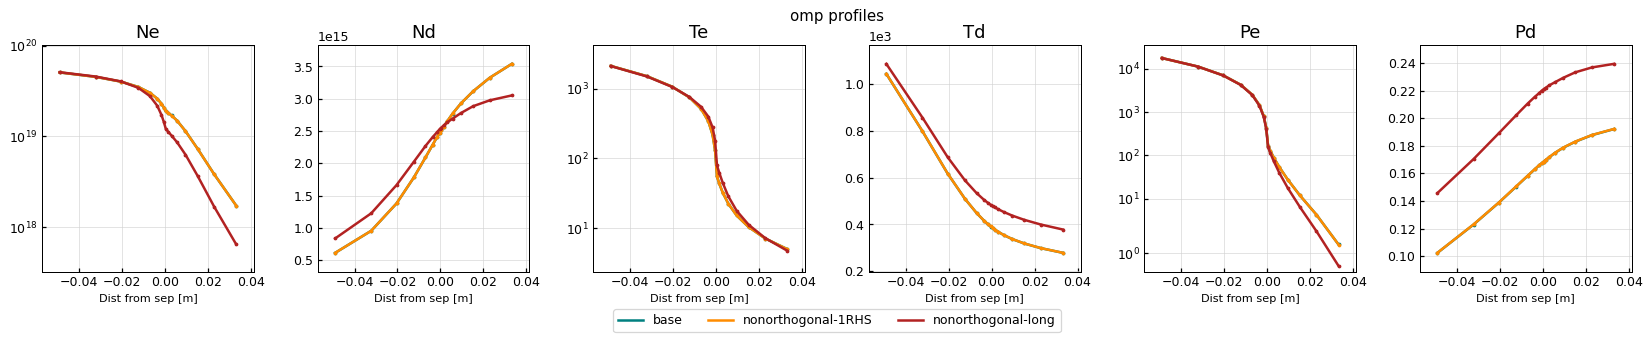

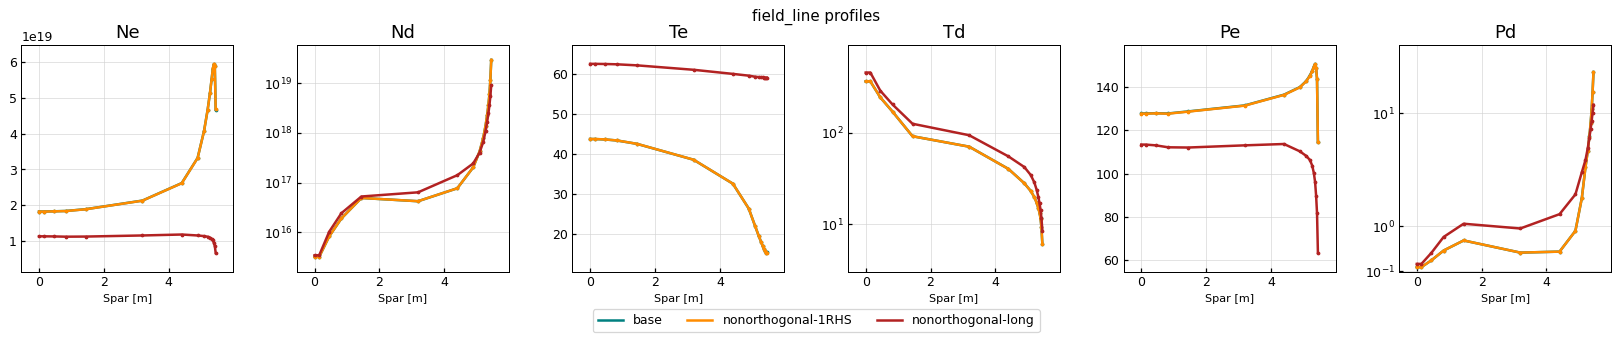

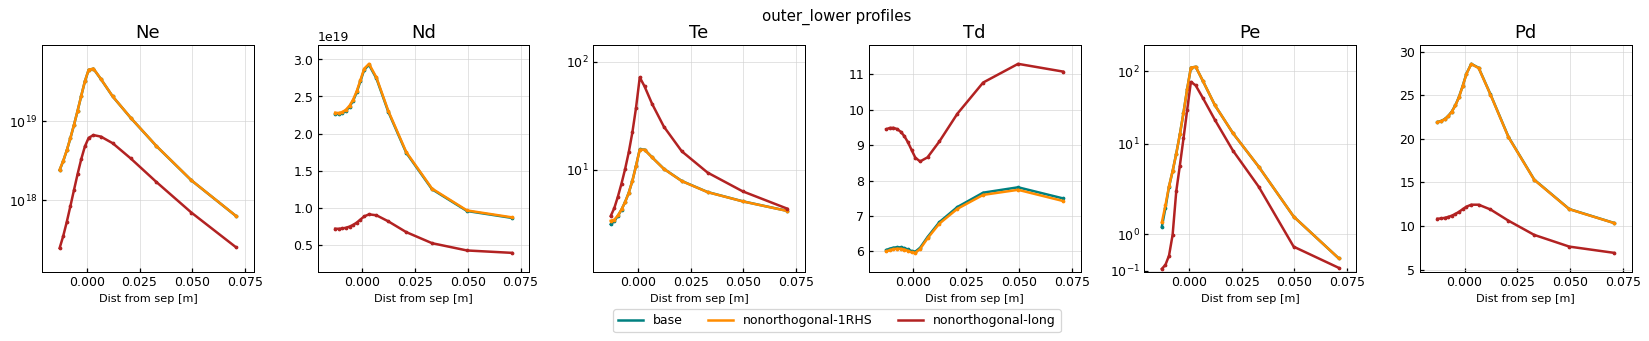

In [62]:
toplot = {}

for case in cs:
    ds = cs[case].ds

    if "t" in ds.sizes:
        ds = ds.isel(t=-1)

    toplot[case] = ds
    
lineplot(
    toplot,
    params = ["Ne", "Nd", "Te", "Td", "Pe", "Pd"],
    regions = ["omp", "field_line", "outer_lower"],
    dpi = 90
)

# Plot transport

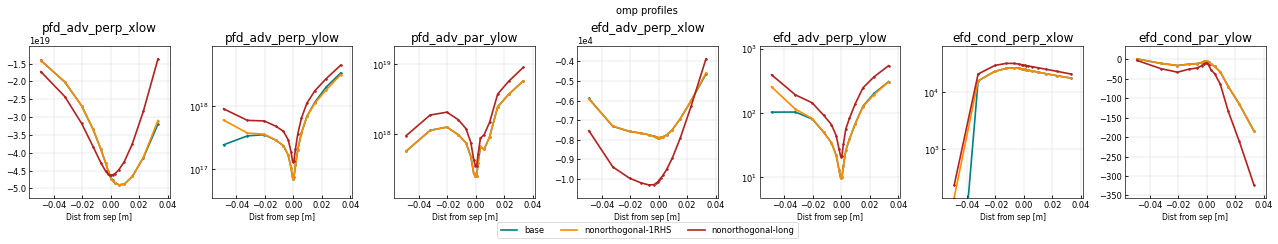

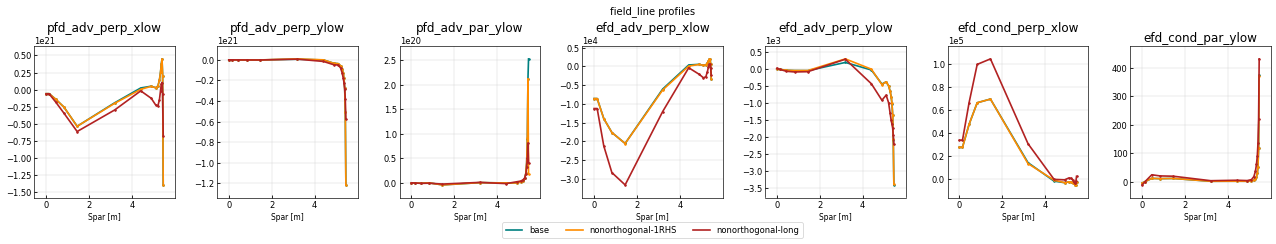

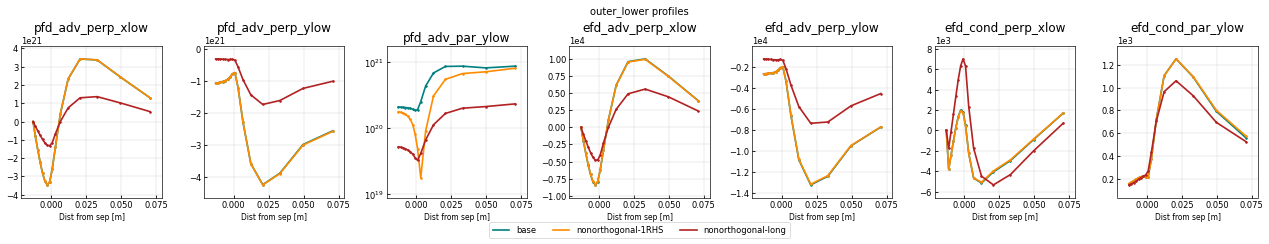

In [203]:
toplot = {}

for case in cs:
    ds = cs[case].ds

    if "t" in ds.sizes:
        ds = ds.isel(t=-1)

    toplot[case] = ds
    
lineplot(
    toplot,
    params = ["pfd_adv_perp_xlow", "pfd_adv_perp_ylow", "pfd_adv_par_ylow" , "efd_adv_perp_xlow", "efd_adv_perp_ylow", "efd_cond_perp_xlow", "efd_cond_par_ylow"],
    regions = ["omp", "field_line", "outer_lower"],
    dpi = 60
)

# Particle balance

In [159]:
%matplotlib inline

KeyError: "No variable named 'Sd_sol_boundary'. Variables on the dataset include ['Bxy', 'Dnnd', 'Ed+_VgradP', 'Ed+_iz', 'Ed+_rec', ..., 'dr', 'hthe', 'dl', 'dtor', 'dpol']"

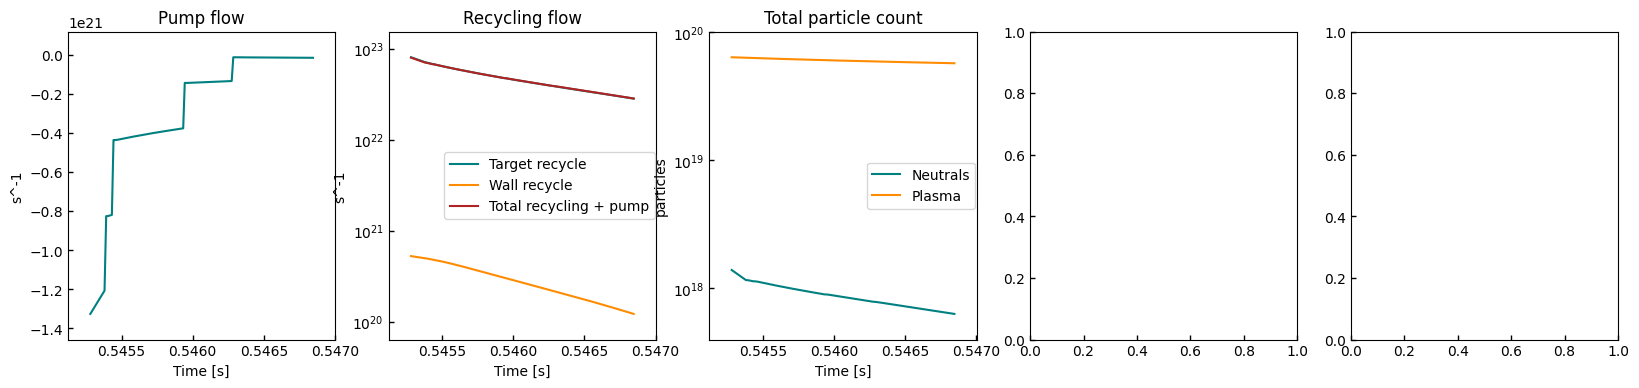

In [207]:
fig, axes = plt.subplots(1,5, figsize = (20,4))

ds = cs["nonorthogonal-long"].ds

ax = axes[0]
(ds["Sd_pump"] * ds["dv"]).sum(("x", "theta")).plot(ax = ax)
ax.set_title("Pump flow")
ax.set_ylabel("s^-1")

ax = axes[1]
(ds["Sd_target_recycle"] * ds["dv"]).sum(("x", "theta")).plot(ax = ax, label = "Target recycle")
(ds["Sd_wall_recycle"] * ds["dv"]).sum(("x", "theta")).plot(ax = ax, label = "Wall recycle")
((ds["Sd_pump"] + ds["Sd_target_recycle"] + ds["Sd_wall_recycle"]) * ds["dv"]).sum(("x", "theta")).plot(ax = ax, label = "Total recycling + pump")
ax.set_title("Recycling flow")
ax.set_ylabel("s^-1")
ax.set_yscale("symlog")
ax.legend()

ax = axes[2]
(ds["Nd"] * ds["dv"]).sum(("x", "theta")).plot(ax = ax, label = "Neutrals")
(ds["Ne"] * ds["dv"]).sum(("x", "theta")).plot(ax = ax, label = "Plasma")
ax.set_title("Total particle count")
ax.legend()
ax.set_ylabel("particles")
ax.set_yscale("log")

ax = axes[3]
(ds["Sd_sol_boundary"] * ds["dv"]).sum(("theta", "x")).plot(ax = ax, label = "Neutrals")
(ds["Sd+_sol_boundary"] * ds["dv"]).sum(("theta", "x")).plot(ax = ax, label = "Plasma")
ax.set_title("SOL boundary flows")
ax.set_ylabel("s^-1")
ax.legend()

ax = axes[4]
(ds["Sd_pfr_boundary"] * ds["dv"]).sum(("theta", "x")).plot(ax = ax, label = "Neutrals")
(ds["Sd+_pfr_boundary"] * ds["dv"]).sum(("theta", "x")).plot(ax = ax, label = "Plasma")
ax.set_title("PFR boundary flows")
ax.set_ylabel("s^-1")
ax.legend()

fig.tight_layout()
# ax.set_yscale("symlog")

In [225]:
cs.keys()

dict_keys(['base', 'nonorthogonal-1RHS', 'nonorthogonal-long'])

Text(0, 0.5, 'Flow into domain [s^-1]')

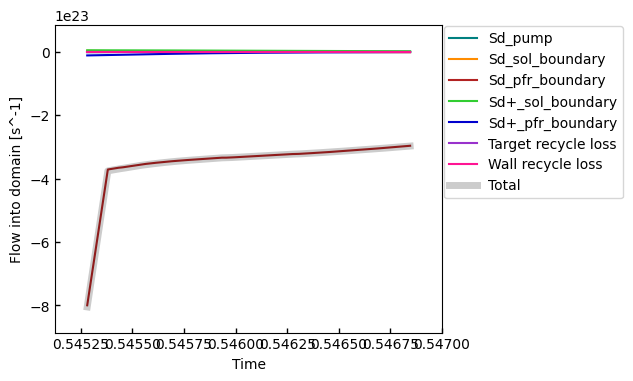

In [226]:
ds = cs["nonorthogonal-long"].ds
ds = ds.hermes.calculate_boundary_flows()
options = ds.options

target_recycle_multiplier = options["d+"]["target_recycle_multiplier"]
sol_recycle_multiplier = options["d+"]["sol_recycle_multiplier"]
pfr_recycle_multiplier = options["d+"]["pfr_recycle_multiplier"]


fig, ax = plt.subplots()

sources = {}

for name in [
    "Sd_pump",
    "Sd_sol_boundary",
    "Sd_pfr_boundary",
    "Sd+_sol_boundary",
    "Sd+_pfr_boundary",
]:
    sources[name] = (ds[name] * ds["dv"]).sum(("x", "theta")).values

    

sources["Target recycle loss"] = (ds["Sd_target_recycle"] * ds["dv"]).sum(("x", "theta")).values * (1 - target_recycle_multiplier) / target_recycle_multiplier
sources["Wall recycle loss"] = (ds["Sd_wall_recycle"] * ds["dv"]).sum(("x", "theta")).values * (1 - sol_recycle_multiplier) / sol_recycle_multiplier


total = []
for name in sources:
    ax.plot(ds["t"], sources[name], label = name)
    total.append(sources[name])

total = np.sum(total, axis = 0)
ax.plot(ds["t"], total, label = "Total", color = "k", lw = 5, alpha = 0.2        )
ax.legend(loc = "upper left", bbox_to_anchor = (1,1))
ax.set_xlabel("Time")
ax.set_ylabel("Flow into domain [s^-1]")

In [227]:
sol = ds.hermes.select_region("sol_boundary")
pfr = ds.hermes.select_region("pfr_boundary")
sol_guard = ds.hermes.select_region("sol_boundary_guard")
pfr_guard = ds.hermes.select_region("pfr_boundary_guard")

for name in ds.metadata["species"]:

    if name in ds.metadata["neutral_species"]:
        flow_diagnostic_name = f"pf{name}_adv_perp_xlow"
    else:
        flow_diagnostic_name = f"pf{name}_tot_xlow"

    if flow_diagnostic_name in ds.data_vars:

        ds[f"S{name}_sol_boundary"] = sol_guard[flow_diagnostic_name] / sol["dv"]
        ds[f"S{name}_sol_boundary"].attrs.update(
            {
                "short_name" : "Particle source",
                "long_name" : f"Particle source of {name} at SOL boundary",
                "units": "m^-3 s^-1"
            }
        )

        ds[f"S{name}_pfr_boundary"] = pfr[flow_diagnostic_name] / pfr["dv"]
        ds[f"S{name}_pfr_boundary"].attrs.update(
            {
                "short_name" : "Particle source",
                "long_name" : f"Particle source of {name} at SOL boundary",
                "units": "m^-3 s^-1"
            }
        )

ds["Sd_pfr_boundary"].isel(t=-5)


<xarray.DataArray 'Sd_pfr_boundary' (theta: 58)> Size: 464B
array([            nan,             nan, -1.30541134e+23, -8.68151276e+23,
       -7.73708758e+23, -2.40426750e+23, -9.94381476e+21,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan, -1.02271496e+22, -2.41456478e+23, -7.64164244e+23,
       -8.49688629e+23, -1.27289878e+23,             nan,             nan,
                   nan,             nan, -9.48174970e+20, -1.92168182e+22,
       -1.92084911e+23, -1.07826564e+24, -3.60494381e+24, -5.58650647e+24,
       -3.14571014e+24, -7.91032995e+23, -8.60889160e+22,  3.33905674e+21,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,  2.97024056e+21, -9.09834335e+22,
       -8.05470516e+23, -3.12069298e+24, -5.40456469e+24, -3.40693834e+24,
       -1.00800097e+24, -1.79825868e+23, -1.63620810e+22, -5.84654623e+20,
                   nan,             nan])
Coordinates:
  * theta      (theta) float64 464B 0.1571 0.4712 0.7854 ... 17.44 17.75 18.06
    t          float64 8B 0.5468
    zeta       float64 8B 3.142
    theta_idx  (theta) int64 464B 0 1 2 3 4 5 6 7 8 ... 50 51 52 53 54 55 56 57
Attributes: (12/15)
    current_time_index:  148
    cell_location:       CELL_CENTRE
    direction_y:         Standard
    direction_z:         Standard
    species:             d
    time_dimension:      t
    ...                  ...
    regions:             {'lower_inner_PFR': <xbout.region.Region>\n\tname\tl...
    geometry:            toroidal
    units_type:          SI
    short_name:          Particle source
    long_name:           Particle source of d at SOL boundary
    units:               m^-3 s^-1

In [157]:
[print(x) for x in ds.data_vars if "Sd" in x]

Sd+_iz
Sd+_rec
Sd+_src
Sd_pump
Sd_src
Sd_target_recycle
Sd_wall_recycle
Sd_sol_boundary
Sd+_sol_boundary
Sd_pfr_boundary
Sd+_pfr_boundary


[None, None, None, None, None, None, None, None, None, None, None]

In [97]:
(sol["pfd_adv_perp_xlow"] * ds["dv"]).dims

('t', 'theta', 'x')

In [138]:
%matplotlib widget

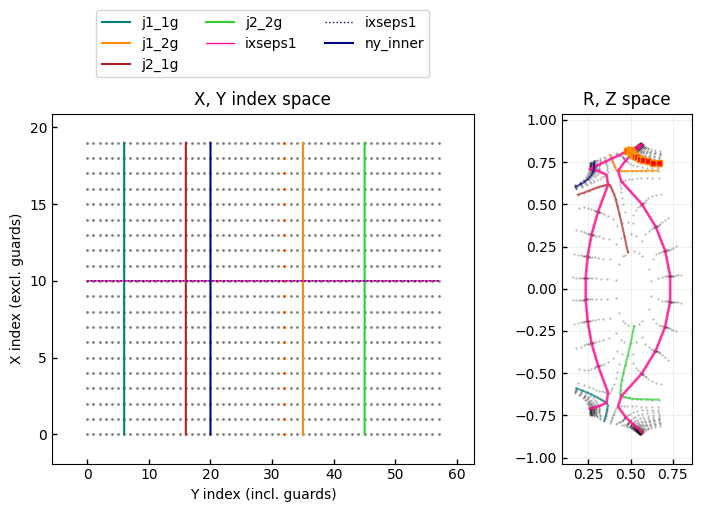

In [239]:
plt.close("all")
plot_selection(ds, ds.isel(t = -1, x = slice(None), theta = 32))

In [ ]:
fig, ax = plt.subplots()

mp = get_1d_radial_data(ds.isel(t=-1), ["pfd_adv_perp_xlow"], region = "outer_midplane", guards = True)

ax.plot(mp["Srad"], mp["pfd_adv_perp_xlow"], marker = "o")
ax.plot(mp["Srad"].values[18], mp["pfd_adv_perp_xlow"].values[18], marker = "x", markersize = 10, label = "Guard point")

Text(0, 0.5, 'Pressure [Pa]')

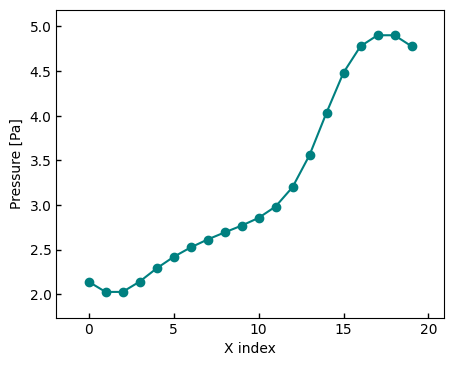

In [232]:
fig, ax = plt.subplots()
reg = ds.isel(t = -1, x = slice(None), theta = 32)
# ax.plot(reg["x"], reg["pfd_adv_perp_xlow"], marker = "o")
ax.plot(reg["x"], reg["Pd"], marker = "o")
ax.set_xlabel("X index")
ax.set_ylabel("Pressure [Pa]")
# ax.plot(mp["Srad"].values[18], mp["pfd_adv_perp_xlow"].values[18], marker = "x", markersize = 10, label = "Guard point")

Text(0, 0.5, 's^-1')

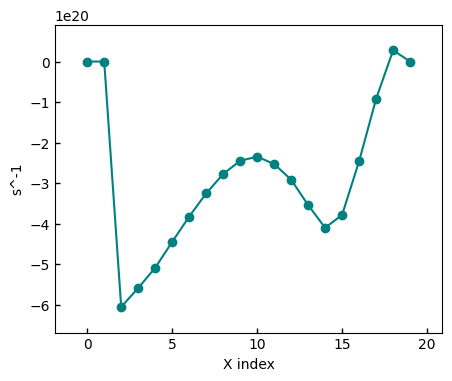

In [244]:
fig, ax = plt.subplots()
reg = ds.isel(t = -1, x = slice(None), theta = 32)
ax.plot(reg["x"], reg["pfd_adv_perp_xlow"], marker = "o")
# ax.plot(reg["x"], reg["Pd"], marker = "o")
ax.set_xlabel("X index")
ax.set_ylabel("s^-1")
# ax.plot(mp["Srad"].values[18], mp["pfd_adv_perp_xlow"].values[18], marker = "x", markersize = 10, label = "Guard point")

# Scan in parallel transport

Text(0, 0.5, 'Parallel advection [s-1]')

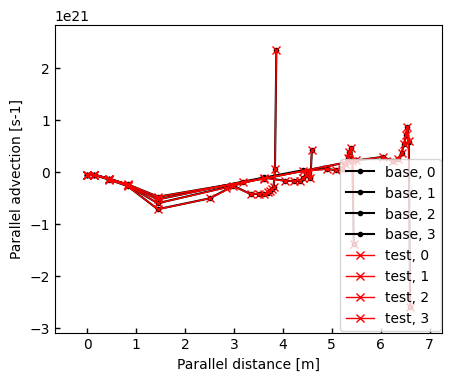

In [54]:
fig, ax = plt.subplots()

styles = dict(
    base = {"c" : "k", "marker" : "o", "ms" : 3},
    test = {"c" : "red", "marker" : "x", "lw" : 1}
)

param = "pfd_adv_par_ylow"

param = "pfd_adv_perp_xlow"

for name in ["base", "test"]:
    ds = cs[name].ds
    ds = ds.isel(t=-1) if "t" in ds.sizes else ds

    for i in range(4):
        fl = get_1d_poloidal_data(ds, [param], "outer_lower", sepadd = i)

        ax.plot(fl["Spar"], fl[param], label = f"{name}, {i}",  **styles[name])

ax.legend()
ax.set_xlabel("Parallel distance [m]")
ax.set_ylabel("Parallel advection [s-1]")
# ax.set_xlim(3,None)
# ax.set_yscale("symlog")
# fl

In [ ]:
ds = cs["base"].ds
ds = ds.isel(t=-1) if "t" in ds.sizes else ds

params = ["pfd_adv_par_ylow", "pfd_adv_perp_xlow", "pfd_adv_perp_ylow"]
toplot = []
for param in params:
    toplot.append(dict(data = ds[param], title = param))

plot2d(
    toplot,
    ylim = (None, 0.1),
)

AttributeError: 'BoutDatasetAccessor' object has no attribute 'final_time'

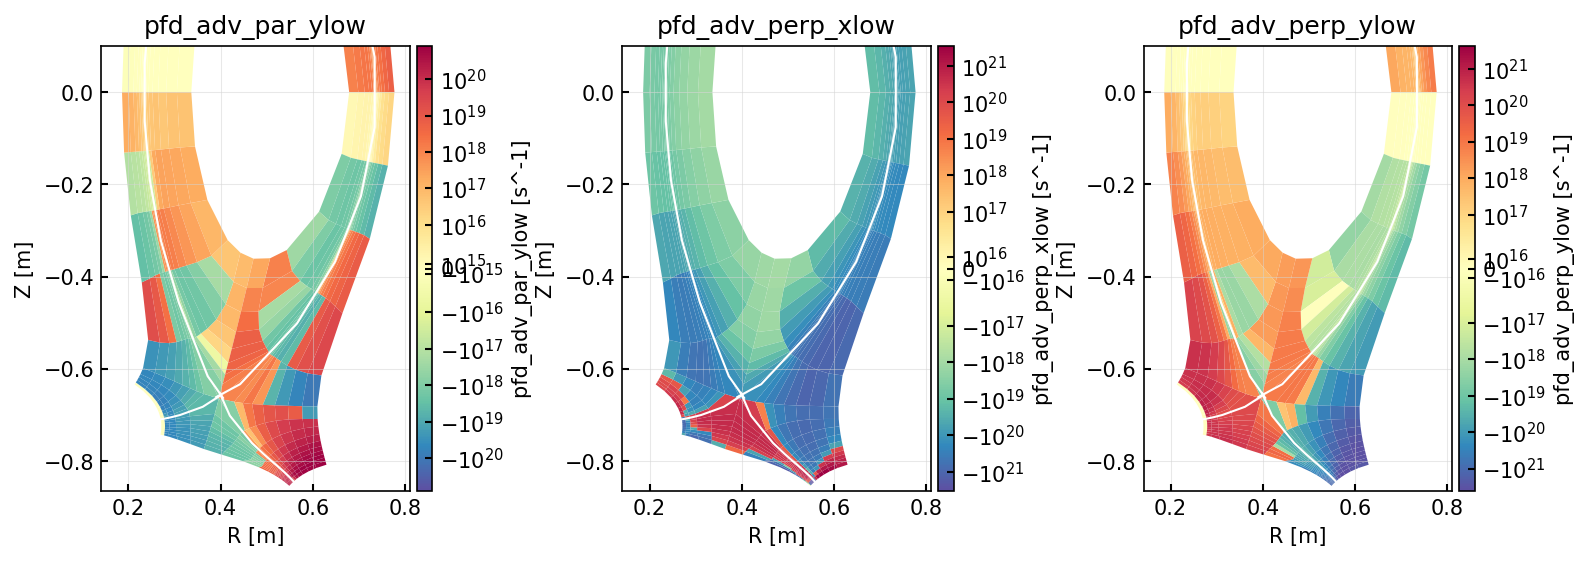

In [18]:
ds = cs["test"].ds
ds = ds.isel(t=-1) if "t" in ds.sizes else ds

params = ["pfd_adv_par_ylow", "pfd_adv_perp_xlow", "pfd_adv_perp_ylow"]
toplot = []
for param in params:
    toplot.append(dict(data = ds[param], title = param))

plot2d(
    toplot,
    ylim = (None, 0.1),
)